In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.opengl)

ImageW = 1000
ImageH = 1000
RN = 64

def mul_bias(X, W):
    ids = tf.indices(list(X.shape[:-1]) + [W.shape[-2]])
    return tf.select(ids[-1] == X.shape[-1], 0.01, X[ids]) @ W

def GELU(x):
    return 0.5*x*(1.0+tf.tanh(0.7978845608*(x+0.044715*x*x*x)))

class TextureEmbedder(tf.Module):
    def __init__(self, embedding_size = RN, embedding_channels = 16, channel_count = 3):
        super().__init__()
        self.embedding_size = embedding_size
        self.channel_count = channel_count
        self.embedding_channels = embedding_channels
        self.hidden_size = 20
        #self.dequant_scale = tf.Parameter([embedding_channels], tf.float32, random_scale = 2.0)
        #self.dequant_bias = tf.Parameter([embedding_channels], tf.float32, random_scale = 0.0)
        self.tex = tf.Parameter([embedding_size, embedding_size, embedding_channels], tf.float32, random_scale = 1.0)
        self.x_to_embed = tf.Parameter([embedding_channels, embedding_channels], tf.float32, random_scale = 2.0)
        self.fc1 = tf.Parameter([embedding_channels+1, self.hidden_size], tf.float32)
        self.fc2 = tf.Parameter([embedding_channels+1, self.hidden_size], tf.float32)
        self.phase_to_embed = tf.Parameter([embedding_channels, embedding_channels], tf.float32, random_scale = 2.00)
        self.fc3 = tf.Parameter([self.hidden_size+1, channel_count], tf.float32)
        self.y_to_embed = tf.Parameter([embedding_channels, embedding_channels], tf.float32, random_scale = 2.0)
        self.gate = tf.Parameter([embedding_channels, embedding_channels], tf.float32, random_scale = 0.2)

    def sample(self, i, j, k):
        res = self.tex[i, j, k]
        #res = tf.clamp(tf.round(127.0*self.tex[i, j, k]).pass_grad(), -127.0, 127.0) / 127.0
        return res

    def neural_sample(self, i, j, x, y, ch):
        x = x - tf.float(i)
        y = y - tf.float(j)
        embed = self.sample(i, j, ch)
        embed = (embed @ self.gate) * tf.cos(x * (embed @ self.x_to_embed) + y * (embed @ self.y_to_embed) + (embed @ self.phase_to_embed))
        embed *= tf.smoothstep(1.5, 0.0, tf.abs(x)) * tf.smoothstep(1.5, 0.0, tf.abs(y))
        return embed

    def learned_interp(self, x, y):
        x = tf.repeat(tf.unsqueeze(x), 9)
        y = y[x.indices[:-1]]
        x = x.T
        y = y.T

        i, j = tf.round(x), tf.round(y)
        ii, jj = tf.int(i), tf.int(j)

        ids = x.indices
        ch = ids[-1]
        it = ids[-2]
        xi = it / 3 - 1
        yi = it % 3 - 1 

        sample = self.neural_sample(ii+xi, jj+yi, x, y, ch)

        return tf.sum(sample, axis = -2)

    def forward(self, x, y):
        embed = self.learned_interp(x, y)
        embed = GELU(mul_bias(embed, self.fc1))*GELU(mul_bias(embed, self.fc2))
        return tf.clamp(mul_bias(embed, self.fc3), 0.0, 1.0)

    def loss(self, X, Y):
        i, j = tf.indices([X.shape[0], self.embedding_channels])
        Yhat = self.forward(X[i, 0], X[i, 1])
        diff = Yhat - Y
        return tf.mean(tf.mean(diff*diff))

def NeuralEmbed():
    pos = tf.input([-1, 2], tf.float32)
    N = pos.shape[0]
    val = tf.input([N, 3], tf.float32)

    info = tf.input([-1], tf.float32)
    learning_rate = info[0]

    model = TextureEmbedder()
    opt = tf.optimizers.adam(model, learning_rate = learning_rate)
    #opt.set_clipping_type(tf.clipping.norm)
    opt.initialize_input()

    loss = opt.step(pos, val)

    params = opt.parameters()
    params.append(loss)
    return params

reconstruct = tf.compile(NeuralEmbed)

def RenderImage():
    model = TextureEmbedder()
    model.initialize_input()

    i, j, e = tf.indices([ImageH, ImageW, model.embedding_channels])
    x, y = tf.float(i*(model.embedding_size-1))/float(ImageH), tf.float(j*(model.embedding_size-1))/float(ImageW)
    x = tf.float(model.embedding_size-1) - x

    return model.forward(x, y)

render = tf.compile(RenderImage)

TensorFrost module loaded!
NeuralEmbed:
  Kernel count: 52
  Intermediate buffers: 47
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 747
  IR Compile time: 73.216301 ms
  Host Compile time: 1637.161987 ms
  Shader Compile time: 266.611023 ms

RenderImage:
  Kernel count: 9
  Intermediate buffers: 11
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 539
  IR Compile time: 16.432501 ms
  Host Compile time: 1434.104614 ms
  Shader Compile time: 72.624100 ms



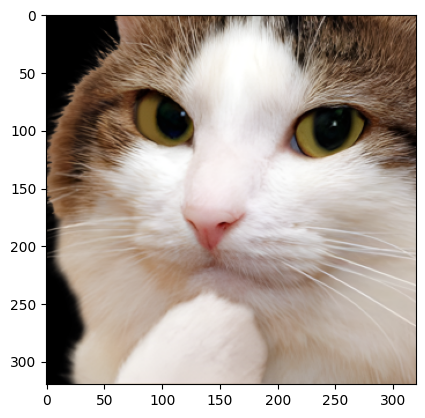

(320, 320, 3)


In [14]:
input_img = np.array(plt.imread("test.png"), dtype=np.float32)
input_img = input_img[:,:,:3] * input_img[:,:,3:4]
plt.imshow(input_img)
plt.show()
print(input_img.shape)


In [11]:
#get list of pixels
N = input_img.shape[0]*input_img.shape[1]
pos = np.zeros((N, 2))
vals = np.zeros((N, 3))
for i in range(input_img.shape[0]):
    for j in range(input_img.shape[1]):
        pos[i*input_img.shape[1]+j] = [i/input_img.shape[0], j/input_img.shape[1]]
        vals[i*input_img.shape[1]+j] = input_img[i, j]

pos *= (np.array([RN - 1, RN - 1]))

#randomize the order
order = np.arange(N)
np.random.shuffle(order)
pos = pos[order]
vals = vals[order]

In [12]:
model = TextureEmbedder()
opt = tf.optimizers.adam(model)
opt.initialize_parameters()

In [13]:
import time

tf.window.show(ImageW, ImageH, "reconstruction")

prev_time = time.time()
smooth_delta_time = 0.0
do_optimization = False

lr = 0.001
normalize = True

batch_size = 256
iters_per_frame = 16
loss_hist = []
loss_val = 0.0
freeze_weights = False
freeze_tex = False

while not tf.window.should_close():
    cur_time = time.time()

    delta_time = cur_time - prev_time
    smooth_delta_time = 0.9 * smooth_delta_time + 0.1 * delta_time

    if do_optimization:
        params = [0.0 if freeze_tex else lr, 0.0 if freeze_weights else lr]
        for _ in range(iters_per_frame):
            rand_offset = np.random.randint(N - batch_size)
            pos_tf = tf.tensor(pos[rand_offset:rand_offset+batch_size])
            vals_tf = tf.tensor(vals[rand_offset:rand_offset+batch_size])
            output = reconstruct(pos_tf, vals_tf, params, opt)
            loss = output[-1]
            opt.update_parameters(output[:-1])
        loss_val = loss.numpy
        loss_hist.append(loss_val)

    normalize = False

    tf.window.render_frame(render(model))
    tf.imgui.text("Frame time: %.3f ms" % (1000.0 * smooth_delta_time))
    tf.imgui.text("FPS: %.1f" % (1.0 / (smooth_delta_time + 1e-5)))
    do_optimization = tf.imgui.checkbox("Optimize", do_optimization)
    tf.imgui.text("Loss: %.5f" % loss_val)
    lr = tf.imgui.slider("Learning rate", lr, 0.0, 0.1)
    iters_per_frame = tf.imgui.slider("Iterations per frame", iters_per_frame, 1, 100)
    batch_size = tf.imgui.slider("Batch size", batch_size, 64, 10000)
    freeze_weights = tf.imgui.checkbox("Freeze weights", freeze_weights)
    freeze_tex = tf.imgui.checkbox("Freeze texture", freeze_tex)
    normalize = tf.imgui.checkbox("Normalize", normalize)
    
    prev_time = cur_time

print("Final loss: %.5f" % loss_val)

C:\Users\micha\AppData\Local\Temp\ipykernel_2976\2381237510.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tf.imgui.text("Loss: %.5f" % loss_val)


Final loss: 0.00219


C:\Users\micha\AppData\Local\Temp\ipykernel_2976\2381237510.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Final loss: %.5f" % loss_val)


In [6]:
# embedding = model.tex.numpy
# #plot histogram for each channel
# for i in range(embedding.shape[-1]):
#     plt.hist(embedding[:,:,i].flatten(), bins=16)
#     plt.show()
